# TradingView's PineScript strategy conversion example

A bollinger band example strategy conversion

This is an example notebook how to create and run backtests with
[Trading Strategy DeFi algorithmic trading framework](https://tradingstrategy.ai/docs/programming/api/execution/index.html).

This is an example trading strategy backtest prepared for [Avalance Summit II workshop](https://tradingstrategy.ai/blog/avalanche-summit-ii-workshop).
For more information see [the README on Github repository](https://github.com/tradingstrategy-ai/tradingview-defi-strategy).

### Github notebook rendering issues

**If you are viewing this file on Github**: The current Github online notebook viewer cannot render the interactive Plotly charts used in this notebook.
To view the charts, you need to download run the notebook locally.

## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for technical indicators

In [111]:
import datetime
from datetime import timezone

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import TradeRouting, ReserveCurrency

#
# Strategy properties
# 

# How our trades are routed.
TRADE_ROUTING = TradeRouting.trader_joe_usdc

# How often the strategy performs the decide_trades cycle.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_4h

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h1

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.m15

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Which trading pair we are backtesting on
# (Might be different from the live trading pair)
# https://tradingstrategy.ai/trading-view/polygon/quickswap/eth-usdc
TRADING_PAIR = (ChainId.avalanche, "trader-joe", "WAVAX", "USDC")

# How much % of the cash to put on a single trade
POSITION_SIZE = 0.50

# Start with this amount of USD
INITIAL_DEPOSIT = 5_000

#
# Strategy inputs
#

# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 90

# How many candles we use to calculate the Relative Strength Indicator
RSI_LENGTH = 14

# RSI must be above this value to open a new position.
RSI_THRESHOLD = 65

# What's the moving average length in candles for Bollinger bands
MOVING_AVERAGE_LENGTH = 20

# Bollinger band's standard deviation
STDDEV = 2.0

# Backtest range
#
# Note that for this example notebook we deliberately choose a very short period,
# as the backtest completes faster, charts are more readable
# and tables shorter for the demostration.
#
START_AT = datetime.datetime(2022, 3, 1)

# Backtest range
END_AT = datetime.datetime(2022, 3, 6, 16, tzinfo=timezone.utc)

# Stop loss relative to the mid price during the time when the position is opened
#
# If the price drops below this level, trigger a stop loss
STOP_LOSS_PCT = 0.98


## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- See README for explanations on technical indicators used


In [112]:
from typing import List, Dict

import pandas as pd
from pandas_ta import bbands
from pandas_ta.overlap import ema
from pandas_ta.momentum import rsi

from tradingstrategy.universe import Universe

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager


def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle.

    - Reads incoming execution state (positions, past trades)

    - Reads the current universe (candles)

    - Decides what trades to do next, if any, at current timestamp.

    - Outputs strategy thinking for visualisation and debug messages

    :param timestamp:
        The Pandas timestamp object for this cycle. Matches
        TRADING_STRATEGY_CYCLE division.
        Always truncated to the zero seconds and minutes, never a real-time clock.

    :param universe:
        Trading universe that was constructed earlier.

    :param state:
        The current trade execution state.
        Contains current open positions and all previously executed trades, plus output
        for statistics, visualisation and diangnostics of the strategy.

    :param pricing_model:
        Pricing model can tell the buy/sell price of the particular asset at a particular moment.

    :param cycle_debug_data:
        Python dictionary for various debug variables you can read or set, specific to this trade cycle.
        This data is discarded at the end of the trade cycle.

    :return:
        List of trade instructions in the form of :py:class:`TradeExecution` instances.
        The trades can be generated using `position_manager` but strategy could also hand craft its trades.
    """

    # Trades generated in this cycle
    trades = []

    # We have only a single trading pair for this strategy.
    pair = universe.pairs.get_single()

    # Here we manipulate the pair trading fee.
    #
    # A live trading would happen on TraderJoe AVAX-USDC pool with 0.20% LP fee.
    # https://traderjoexyz.com/avalanche/pool/v21/AVAX/0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e/20
    # But this pool was deployed only couple of weeks back, so we do not have backtesting history for it.
    # Thus, we are backtesting with the old pair with 0.30% LP fee tier for more data.
    # We then manually bump down the fee tier to reflect the live trading situation.
    pair.fee = 0.0020

    # How much cash we have in a hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=LOOKBACK_WINDOW)

    if len(candles) == 0:
        # We are looking back so far in the history that the pair is not trading yet
        return trades

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    price_latest = close_prices.iloc[-1]
    print(close_prices)

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)

    # Calculate RSI for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
    rsi_series = rsi(close_prices, length=RSI_LENGTH)
    if rsi_series is None:
        # Not enough data in the backtesting buffer yet
        return trades

    # Calculate Bollinger Bands with a 20-day SMA and 2 standard deviations using pandas_ta
    # See documentation here https://tradingstrategy.ai/docs/programming/api/technical-analysis/volatility/help/pandas_ta.volatility.bbands.html#bbands
    bollinger_bands = bbands(close_prices, length=MOVING_AVERAGE_LENGTH, std=STDDEV)

    if bollinger_bands is None:
        # Not enough data in the backtesting buffer yet
        return trades

    # bbands() returns a dictionary of items with different name mangling
    bb_upper = bollinger_bands[f"BBU_{MOVING_AVERAGE_LENGTH}_{STDDEV}"]
    bb_lower = bollinger_bands[f"BBL_{MOVING_AVERAGE_LENGTH}_{STDDEV}"]
    bb_mid = bollinger_bands[f"BBM_{MOVING_AVERAGE_LENGTH}_{STDDEV}"]  # Moving average

    if not position_manager.is_any_open():
        # No open positions, decide if BUY in this cycle.
        # We buy if the price on the daily chart closes above the upper Bollinger Band.
        if price_latest > bb_upper.iloc[-1] and rsi_series[-1] >= RSI_THRESHOLD:
            buy_amount = cash * POSITION_SIZE
            trades += position_manager.open_1x_long(
                pair, 
                buy_amount, 
                stop_loss_pct=STOP_LOSS_PCT)

    else:
        # We have an open position, decide if SELL in this cycle.
        # We close the position when the price closes below the 20-day moving average.        
        if price_latest < bb_mid.iloc[-1]:
            trades += position_manager.close_all()
        
    # Visualise our technical indicators
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "BB upper", PlotKind.technical_indicator_on_price, bb_upper.iloc[-1], colour="darkblue")
    visualisation.plot_indicator(timestamp, "BB lower", PlotKind.technical_indicator_on_price, bb_lower.iloc[-1], colour="darkblue")
    visualisation.plot_indicator(timestamp, "BB mid", PlotKind.technical_indicator_on_price, bb_mid.iloc[-1], colour="blue")

    # Draw the RSI indicator on a separate chart pane.
    # Visualise the high RSI threshold we must exceed to take a position.
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, rsi_series[-1])
    visualisation.plot_indicator(timestamp, "RSI threshold", PlotKind.technical_indicator_overlay_on_detached, RSI_THRESHOLD, colour="red", detached_overlay_name="RSI")

    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [113]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import load_pair_data_for_single_exchange, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    
    # Fetch backtesting datasets from the server 
    dataset = load_pair_data_for_single_exchange(
        client,
        time_bucket=CANDLE_TIME_BUCKET,
        pair_tickers=[TRADING_PAIR],
        execution_context=execution_context,        
        universe_options=universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Convert loaded data to a trading pair universe
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        pair=TRADING_PAIR,
    )

    return universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [114]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/alpha/.tradingstrategy


## Load data

This will pull JSONL data feed for the trading pair from Trading Strategy oracle node.

In [115]:
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

Loading OHLCV data for 43114-trader-joe:   0%|          | 0/45244604 [00:00<?, ?it/s]

We loaded 12,565 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.


In [116]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="Bollinger bands example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/489600 [00:00<?, ?it/s]

timestamp
2022-02-25 06:00:00    75.521631
2022-02-25 07:00:00    75.496192
2022-02-25 08:00:00    74.638576
2022-02-25 09:00:00    74.136849
2022-02-25 10:00:00    74.177757
                         ...    
2022-02-28 19:00:00    80.364920
2022-02-28 20:00:00    81.619650
2022-02-28 21:00:00    81.206900
2022-02-28 22:00:00    83.804351
2022-02-28 23:00:00    84.449040
Name: close, Length: 90, dtype: float64
timestamp
2022-02-25 10:00:00    74.177757
2022-02-25 11:00:00    75.222533
2022-02-25 12:00:00    76.890385
2022-02-25 13:00:00    78.089351
2022-02-25 14:00:00    77.863841
                         ...    
2022-02-28 23:00:00    84.449040
2022-03-01 00:00:00    88.954070
2022-03-01 01:00:00    87.915430
2022-03-01 02:00:00    87.271751
2022-03-01 03:00:00    86.679332
Name: close, Length: 90, dtype: float64
timestamp
2022-02-25 14:00:00    77.863841
2022-02-25 15:00:00    78.358238
2022-02-25 16:00:00    77.654608
2022-02-25 17:00:00    77.581306
2022-02-25 18:00:00    77.024986

## Analysing the backtest results

Examine `state` that contains all actions the trade executor took.


In [117]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.backtest.notebook import setup_charting_and_output
setup_charting_and_output()

# Print extension of our backtest
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 0
Trades made: 0


### Price action and technical indicators

- Plot the prica action for the trading pair we backtested.
- Overlay trades on the top of technical indicators

In [118]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT,
    volume_bar_mode=VolumeBarMode.separate,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

figure.show()

### Equity curve and drawdown

Visualise equity curve and related performnace over time.

- Returns

- Drawdown

- Daily returns



/home/alpha/.cache/pypoetry/virtualenvs/ts-strategy-cuVj3BKY-py3.10/lib/python3.10/site-packages/quantstats/stats.py:293: RuntimeWarning:

invalid value encountered in scalar divide



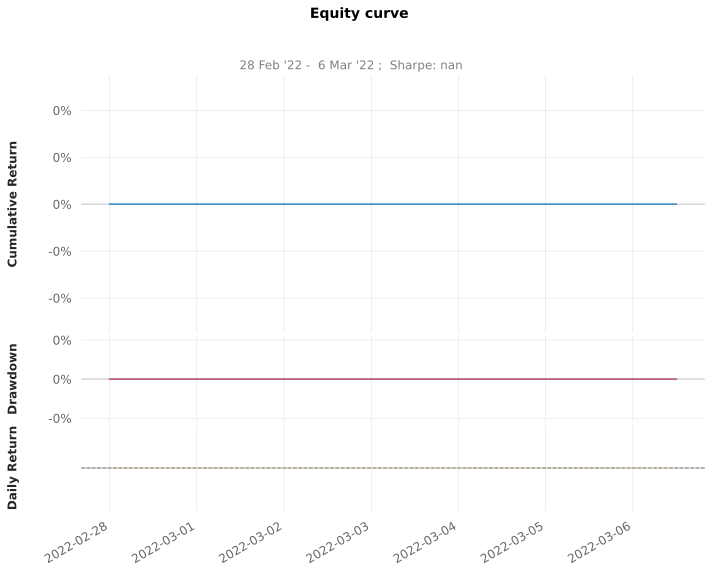

In [119]:
# Needed to improve the resolution of matplotlib chart used here
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

### Returns monthly breakdown

- Monthly returns
- Best day/week/month/year


/home/alpha/.cache/pypoetry/virtualenvs/ts-strategy-cuVj3BKY-py3.10/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



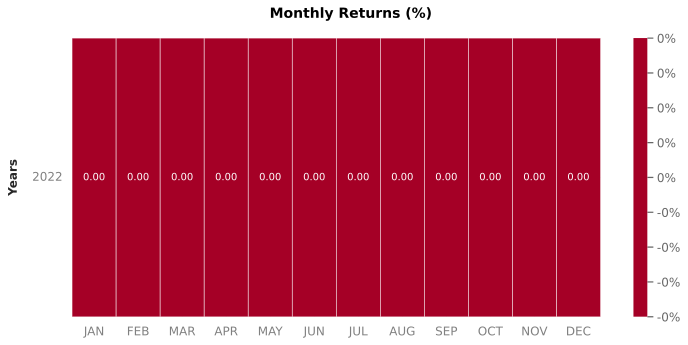

In [120]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

### Returns distribution

Show the difference between good and bad trading periods.

- Daily/montly/yearly

- Best/worst/avg.

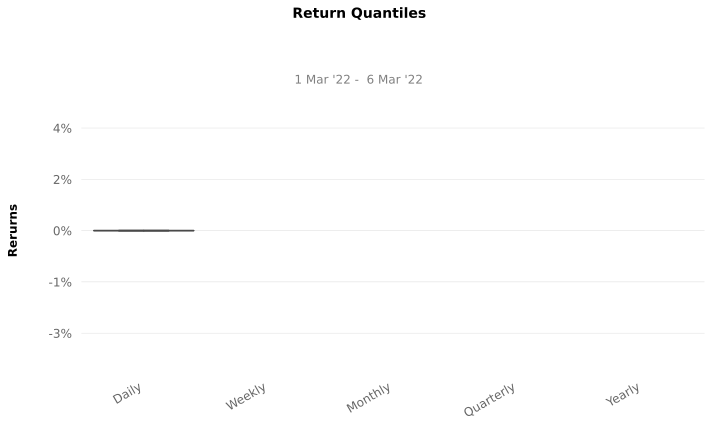

In [121]:
from tradeexecutor.visual.equity_curve import visualise_returns_distribution

visualise_returns_distribution(returns)

### Position chart

- Visualise individual positions over the price timeline

- Hover your mouse on the position marker circle to get its underlying details

- Positions closed for profit are marked green while losing ones are red

In [122]:
candles = universe.universe.candles.get_candles_by_pair(universe.get_single_pair().internal_id)

figure2 = visualise_single_pair_positions_with_duration_and_slippage(
    state,
    candles,
    start_at=START_AT,
    end_at=END_AT,
)

figure2.show()

### Benchmarks

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold ETH


In [123]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "Bollinger bands example strategy",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

### Analyse trade statistics

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [124]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Trading metrics

Overview of trading metrics.

- Returns
- Cash balance change
- Won/lost trades
- Fees paid


In [125]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

,0
Trading period length,-
Return %,0.00%
Annualised return %,-
Cash at start,"$5,000.00"
Value at end,"$5,000.00"
Trade volume,$0.00
Position win percent,-
Total positions,0
Won positions,0
Lost positions,0


### Performance metrics

Here is an example how to use Quantstats library to calculate the tearsheet metrics for the strategy with advanced metrics.
The metrics include popular [risk-adjusted return comparison metrics](https://tradingstrategy.ai/glossary/risk-adjusted-return).

This includes metrics like:

- Sharpe
- Sortino
- Max drawdown

**Note**: These metrics are based on equity curve and returns. Analysis here does not go down to the level of an individual trade or a position.
Any consecutive wins and losses are measured in days, not in trade or candle counts.

In [126]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

/home/alpha/.cache/pypoetry/virtualenvs/ts-strategy-cuVj3BKY-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/home/alpha/.cache/pypoetry/virtualenvs/ts-strategy-cuVj3BKY-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/home/alpha/.cache/pypoetry/virtualenvs/ts-strategy-cuVj3BKY-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning:

invalid value encountered in multiply

/home/alpha/.cache/pypoetry/virtualenvs/ts-strategy-cuVj3BKY-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning:

invalid value encountered in multiply

/home/alpha/.cache/pypoetry/virtualenvs/ts-strategy-cuVj3BKY-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning:

invalid value encountered in multiply

/home/alpha/.cache/pypoetry/virtualenvs/ts-s

,Strategy
Start Period,2022-03-01
End Period,2022-03-06
Risk-Free Rate,0.0%
Time in Market,0.0%
Cumulative Return,0.0%
CAGR﹪,0.0%
Sharpe,-
Prob. Sharpe Ratio,-
Smart Sharpe,-
Sortino,-


### Position and trade timeline

Display all positions and how much profit they made.

In [127]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


,position_id,position


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [128]:
print("All ok")

All ok
